# drive 마운트, seed 고정

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import numpy as np
import random

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import xgboost as xgb
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from sklearn.cluster import MiniBatchKMeans


In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

# 데이터 로드 및 전처리

In [4]:
train_data  = pd.read_csv('/content/drive/MyDrive/날씨 콘테스트/fog_train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/날씨 콘테스트/fog_test.csv')

# 열 이름 변경
train_data.columns = train_data.columns.str.replace('fog_train.', '')
test_data.columns = test_data.columns.str.replace('fog_test.', '')

# 'Unnamed: 0' 열 제거
train_data.drop(columns=['Unnamed: 0'], inplace=True)
test_data.drop(columns=['Unnamed: 0'], inplace=True)

# 테스트 데이터에서 class 열 제거, 목표변수가 test데이터 열에 포함되면 안되기 때문
test_data = test_data.drop(columns=['class'], errors='ignore')

# 필요없는 특성 제거
train_data = train_data.drop(['re'], axis=1)
test_data = test_data.drop(['re'], axis=1)

In [5]:
# 결측값 처리 (-99, -99.9를 NaN으로 대체)
train_data.replace([-99, -99.9], np.nan, inplace=True)
test_data.replace([-99, -99.9], np.nan, inplace=True)

# 결측치 있는 column 분리
cols_with_na = train_data.columns[train_data.isna().any()]
cols_no_na = train_data.columns[~train_data.columns.isin(cols_with_na)]

# vis1의 결측값을 먼저 대체
vis1_imputer = IterativeImputer(random_state=42)
train_data[['vis1']] = vis1_imputer.fit_transform(train_data[['vis1']])

# vis1 값을 바탕으로 class 결측값 대체
def fill_class(row):
    if pd.isna(row['class']):
        if row['vis1'] < 200:
            return 1
        elif 200 <= row['vis1'] < 500:
            return 2
        elif 500 <= row['vis1'] < 1000:
            return 3
        else:
            return 4
    else:
        return row['class']

train_data['class'] = train_data.apply(fill_class, axis=1)

# vis1, class 열을 제외한 나머지 수치형 변수들에 대해 Iterative Imputer 사용
# 결측치 보간을 2단계로 나눈 이유는, test에는 목표변수인 class, 시정구간을 알 수 있는 변수 인 vis1이 없기 때문
# iteratvie 객체 초기화
cols_with_na_no_class = cols_with_na.drop(['vis1','class'])
imputer = IterativeImputer(random_state=42)
train_na = pd.DataFrame(imputer.fit_transform(train_data[cols_with_na_no_class]), columns=cols_with_na_no_class)
test_na = pd.DataFrame(imputer.transform(test_data[cols_with_na_no_class]), columns=cols_with_na_no_class)

# 결측치가 없는 열을 추가
train_data = pd.concat([train_na, train_data.drop(columns=cols_with_na_no_class)], axis=1)
test_data = pd.concat([test_na, test_data.drop(columns=cols_with_na_no_class)], axis=1)

# 파생 변수 추가
train_data['Temp_Diff'] = train_data['ta'] - train_data['ts']
test_data['Temp_Diff'] = test_data['ta'] - test_data['ts']

train_data['Fog_Likelihood_Index'] = (train_data['Temp_Diff'] * train_data['hm']) / (train_data['ws10_ms'] + 1)
test_data['Fog_Likelihood_Index'] = (test_data['Temp_Diff'] * test_data['hm']) / (test_data['ws10_ms'] + 1)

# 시간 특성 추가 (10분 단위)
def add_time_features(df):
    # 시간 변환: 분 단위로 표현된 시간을 24시간 내의 각 위치로 변환
    df['minute_sin'] = np.sin(2 * np.pi * df['minute'] / (24 * 60))
    df['minute_cos'] = np.cos(2 * np.pi * df['minute'] / (24 * 60))
    return df

# train과 test 데이터에 시간 특성 추가
train_data = add_time_features(train_data)
test_data = add_time_features(test_data)

# anomaly 변수 추가할 열
anomaly_columns = ['Temp_Diff', 'hm', 'ws10_ms', 'Fog_Likelihood_Index', 'ta', 'ts', 'sun10']

# 지점 및 연도별 평균 계산 후 anomaly 변수 추가
def add_anomaly_features(df, group_cols, anomaly_cols):
    mean_df = df.groupby(group_cols)[anomaly_cols].transform('mean')
    anomaly_df = df[anomaly_cols] - mean_df
    anomaly_df.columns = [f"{col}_anomaly" for col in anomaly_df.columns]
    return pd.concat([df, anomaly_df], axis=1)

train_data = add_anomaly_features(train_data, ['stn_id', 'year'], anomaly_columns)
test_data = add_anomaly_features(test_data, ['stn_id', 'year'], anomaly_columns)

# 풍향을 주기적인 특성으로 변환하는 함수
def transform_wind_direction(df):
    df['ws10_deg_sin'] = np.sin(np.deg2rad(df['ws10_deg']))
    df['ws10_deg_cos'] = np.cos(np.deg2rad(df['ws10_deg']))
    return df

# 데이터프레임에 변환 적용
train_data = transform_wind_direction(train_data)
test_data = transform_wind_direction(test_data)


# 필요없는 열 제거
train_data.drop(columns=[ 'ws10_deg', 'Temp_Diff', 'hm', 'ws10_ms', 'Fog_Likelihood_Index', 'ta', 'ts', 'sun10'], inplace=True)
test_data.drop(columns=['ws10_deg', 'Temp_Diff', 'hm', 'ws10_ms', 'Fog_Likelihood_Index', 'ta', 'ts', 'sun10'], inplace=True)


#XGBOOST

In [6]:
# 검증용 데이터로 사용할 (year, 지역) 목록
val_regions = [
    ('AA', 'I'),
    ('EC', 'J'),
    ('DA', 'K'),
    ('BB', 'K'),
    ('CA', 'K'),
    ('AB', 'J'),
    ('AD', 'K'),
    ('BA', 'I'),
    ('DB', 'J')
]

# year와 지역 조건에 맞는 데이터 필터링
conditions = [(train_data['stn_id'] == stn_id) & (train_data['year'] == year) for stn_id, year in val_regions]
val_condition = conditions[0]
for condition in conditions[1:]:
    val_condition |= condition

train_data_val = train_data[val_condition]
train_data_train = train_data[~val_condition]

train_data_val.drop(columns=['stn_id', 'year' ], inplace=True)
train_data_train.drop(columns=['stn_id', 'year' ], inplace=True)

# 특징과 라벨 분리
X_train = train_data_train.drop(['class','vis1'], axis=1)
y_train = train_data_train['class']

X_val = train_data_val.drop(['class','vis1'], axis=1)
y_val = train_data_val['class']

In [7]:
# 각 클래스의 샘플 개수 확인
class_counts = y_train.value_counts()

# 샘플링 전략 설정
sampling_strategy = {
    1: int(class_counts[1] * 15.0),  # 클래스 1의 목표 샘플 수
    2: int(class_counts[2] * 15.0),  # 클래스 2의 목표 샘플 수
    3: int(class_counts[3] * 15.0),  # 클래스 3의 목표 샘플 수
    4: class_counts[4]  # 클래스 4는 원래 개수 유지
}

# 오버샘플링 적용
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# 오버샘플링 적용 후 클래스 비율 확인
print("Class distribution after SMOTE:")
print(pd.Series(y_train).value_counts(normalize=True))

Class distribution after SMOTE:
class
4.0    0.865686
2.0    0.051121
3.0    0.050808
1.0    0.032384
Name: proportion, dtype: float64


In [8]:
# 클래스 라벨을 0부터 시작하도록 변환
y_train -= 1
y_val -= 1

# 클래스 가중치 계산
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}

# 가중치 부여
weights = np.array([class_weights[label] for label in y_train])

# DMatrix 생성
dtrain = xgb.DMatrix(X_train, label=y_train, weight=weights)
dval = xgb.DMatrix(X_val, label=y_val)

# XGBoost 모델 학습
param = {
    'objective': 'multi:softmax',
    'num_class': 4,
    'eval_metric': 'mlogloss',
    'eta': 0.3,
    'max_depth': 6,
    'seed': 42
}

num_round = 1000
evallist = [(dval, 'eval'), (dtrain, 'train')]
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10)

# 예측
y_pred = bst.predict(dval)

# 클래스 라벨을 원래대로 복원
y_val += 1
y_pred += 1

# 혼동 행렬 계산
cm = confusion_matrix(y_val, y_pred, labels=[1, 2, 3, 4])

# 혼동 행렬 출력
print("Confusion Matrix:")
print(cm)

# 다중 CSI 계산
H = cm[0, 0] + cm[1, 1] + cm[2, 2]  # H11, H22, H33
F = (cm[0, 1] + cm[0, 2] + cm[1, 0] +
     cm[1, 2] + cm[2, 0] + cm[2, 1] +
     cm[3, 0] + cm[3, 1] + cm[3, 2]) # F12, F13, F21, F23, F31, F32, F41, F42, F43
M = cm[0, 3] + cm[1, 3] + cm[2, 3]  # M14, M24, M34

CSI = H / (H + F + M)
print(f"CSI: {CSI:.2f}")

[0]	eval-mlogloss:1.09405	train-mlogloss:1.24904
[1]	eval-mlogloss:0.92946	train-mlogloss:1.16380
[2]	eval-mlogloss:0.82121	train-mlogloss:1.10464
[3]	eval-mlogloss:0.74774	train-mlogloss:1.06155
[4]	eval-mlogloss:0.69205	train-mlogloss:1.02610
[5]	eval-mlogloss:0.65641	train-mlogloss:0.99890
[6]	eval-mlogloss:0.62731	train-mlogloss:0.97786
[7]	eval-mlogloss:0.60433	train-mlogloss:0.95876
[8]	eval-mlogloss:0.58578	train-mlogloss:0.94205
[9]	eval-mlogloss:0.57181	train-mlogloss:0.92693
[10]	eval-mlogloss:0.56055	train-mlogloss:0.91403
[11]	eval-mlogloss:0.55054	train-mlogloss:0.90263
[12]	eval-mlogloss:0.53524	train-mlogloss:0.89213
[13]	eval-mlogloss:0.52520	train-mlogloss:0.88277
[14]	eval-mlogloss:0.51381	train-mlogloss:0.87236
[15]	eval-mlogloss:0.51039	train-mlogloss:0.86532
[16]	eval-mlogloss:0.49342	train-mlogloss:0.85468
[17]	eval-mlogloss:0.48399	train-mlogloss:0.84764
[18]	eval-mlogloss:0.47045	train-mlogloss:0.83845
[19]	eval-mlogloss:0.46624	train-mlogloss:0.83218
[20]	eval-

Feature Importance:
                         Feature  Importance
9   Fog_Likelihood_Index_anomaly     32365.0
7                     hm_anomaly     23589.0
1                            day     19437.0
12                 sun10_anomaly     18665.0
6              Temp_Diff_anomaly     17279.0
8                ws10_ms_anomaly     16868.0
10                    ta_anomaly     16657.0
13                  ws10_deg_sin     16248.0
14                  ws10_deg_cos     15907.0
11                    ts_anomaly     15346.0
2                           time     14642.0
3                         minute      9677.0
0                          month      9556.0
5                     minute_cos      4231.0
4                     minute_sin      1678.0


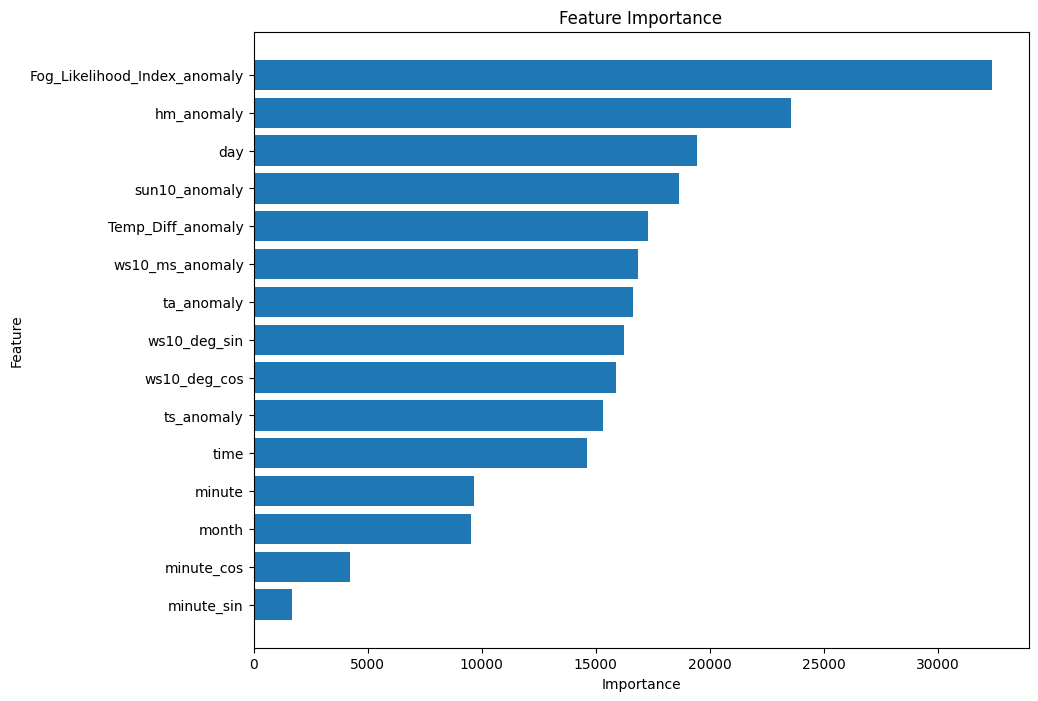

In [9]:
# Feature importance 구하기
importance = bst.get_score(importance_type='weight')
importance_df = pd.DataFrame(importance.items(), columns=['Feature', 'Importance'])

# 중요도 내림차순으로 정렬
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# feature importance 출력
print("Feature Importance:")
print(importance_df)

# 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

In [12]:
test_data.drop(columns=['stn_id', 'year' ], inplace=True)

In [ ]:
# 테스트 데이터 예측
dtest = xgb.DMatrix(test_data)
y_test_pred = bst.predict(dtest)

# 예측 결과를 원래 클래스 라벨로 변환
y_test_pred = y_test_pred.astype(int) + 1

# 제출하기 위해 test데이터 다시 불러옴
sub_test_data = pd.read_csv('/content/drive/MyDrive/날씨 콘테스트/fog_test.csv')
sub_test_data = sub_test_data.drop(columns=['fog_test.class'], errors='ignore')

# 예측 결과를 데이터프레임으로 저장
sub_test_data['fog_test.class'] = y_test_pred

# 예측 결과 저장
sub_test_data.to_csv('240184.csv', index=False)
sub_test_data["fog_test.class"].value_counts()

In [ ]:
sub_test_data["fog_test.class"].value_counts(normalize=True)

In [ ]:
# 파일 다운로드
from google.colab import files
files.download('240184.csv')